# Split 3

Section 4.3 of lab1b

## Question 1

1. Create time series dataset

In [1]:
import numpy as np
from tools import mackey_glass_time_series

steps = np.arange(301, 1501)
x = mackey_glass_time_series(np.max(steps)+5)
input = np.array([[x[t-21], x[t-16], x[t-11], x[t-6], x[t-1]] for t in steps])
output = np.array([x[t+4] for t in steps])

2. Plot data

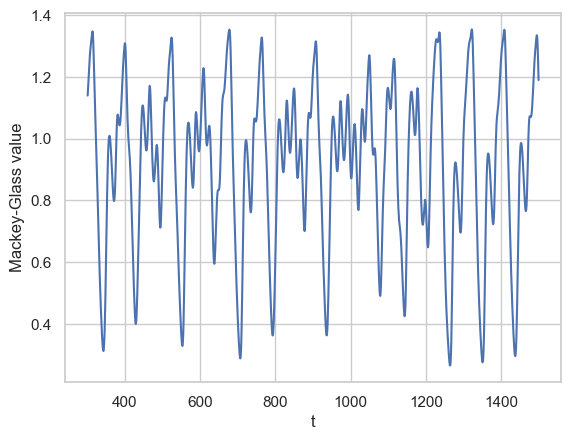

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(context="notebook", style="whitegrid")

sns.lineplot(x=steps, y=output)
plt.xlabel("t")
plt.ylabel("Mackey-Glass value")
plt.savefig("imgs/time_series.pdf")

3. Split into training, validation, and test sets

In [3]:
X_train = input[:-400]
X_val = input[-400:-200]
X_test = input[-200:]

y_train = output[:-400]
y_val = output[-400:-200]
y_test = output[-200:]

The validation subset will be determined through the cross validation scheme.

## Question 2

In [5]:
from sklearn.metrics import mean_squared_error
from tools import TimeSeriesMLP, plot_training_histories
from itertools import product
from tqdm.notebook import tqdm
from warnings import filterwarnings
import pandas as pd

filterwarnings("ignore", category=UserWarning)

histories = {}
layers_config = list(product([3, 4, 5], [2, 4, 6]))

layers_config = tqdm(layers_config)
for layers in layers_config:
    layers_config.set_description_str(f"Evaluating {layers}...")

    history = {
        "train_loss": [],
        "val_loss": [],
        "test_loss": [],
        "best_loss": [],
        "epoch": [],
    }
    for _ in tqdm(range(10), leave=False):
        model = TimeSeriesMLP(hidden_nodes=layers)
        h = model.fit(X_train, y_train, X_val, y_val)
        history["train_loss"] += h["loss"]
        history["val_loss"] += h["val_loss"]
        history["test_loss"] += [model.evaluate(X_test, y_test)] * len(h["loss"])
        history["best_loss"] += [h["val_loss"][-1]] * len(h["loss"])
        history["epoch"] += (np.arange(len(h["loss"])) + 1).tolist()

    history = pd.DataFrame(history)
    history = history.groupby("epoch").agg(["mean", "std"])
    histories[layers] = history.reset_index().to_dict("list")

fig, _ = plot_training_histories(histories)
fig.savefig("imgs/layers_selection.pdf")

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.9617 - val_loss: 0.7501
Epoch 2/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7615 - val_loss: 0.5958
Epoch 3/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6141 - val_loss: 0.4733
Epoch 4/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4773 - val_loss: 0.3809
Epoch 5/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3699 - val_loss: 0.3101
Epoch 6/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3122 - val_loss: 0.2555
Epoch 7/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2592 - val_loss: 0.2133
Epoch 8/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2215 - val_loss: 0.1811
Epoch 9/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1805 - val_loss: 0.1556
Epoch 10/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1538 - val_loss: 0.1359
Epoch 11/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1348 - val_loss: 0.1205
Epoch 12/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.

TypeError: 'float' object is not iterable

In [5]:
final_val_errors = {
    config: (history[('best_loss', 'mean')][-1], history[('best_loss', 'std')][-1])
    for config, history in histories.items()
}

ranked_by_final = sorted(
    final_val_errors.items(),
    key=lambda x: x[1][0],
)

print("Rankings by final validation error:")
for i, (config, error) in enumerate(ranked_by_final, 1):
    print(f"{i}. Architecture {config}: {error[0]:.4f} (std = {error[1]:.4f})")

Rankings by final validation error:
1. Architecture (3, 2): 0.0162 (std = nan)
2. Architecture (5, 6): 0.0186 (std = nan)
3. Architecture (5, 4): 0.0225 (std = nan)
4. Architecture (4, 6): 0.0233 (std = nan)
5. Architecture (3, 6): 0.0243 (std = nan)
6. Architecture (4, 4): 0.0775 (std = nan)
7. Architecture (3, 4): 0.0783 (std = nan)
8. Architecture (4, 2): 0.0788 (std = nan)
9. Architecture (5, 2): 0.0790 (std = nan)


In [6]:
best_test = histories[ranked_by_final[0][0]][("test_loss", "mean")][-1]
worst_test = histories[ranked_by_final[-1][0]][("test_loss", "mean")][-1]

print(f"Best model performance on test set: {best_test}")
print(f"Worst model performance on test set: {worst_test}")

Best model performance on test set: 0.022135469673230455
Worst model performance on test set: 0.10090042575613924


Epoch 1/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.3669 - val_loss: 0.2917
Epoch 2/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2967 - val_loss: 0.2289
Epoch 3/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2282 - val_loss: 0.1784
Epoch 4/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1758 - val_loss: 0.1400
Epoch 5/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1307 - val_loss: 0.1132
Epoch 6/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1050 - val_loss: 0.0962
Epoch 7/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0845 - val_loss: 0.0875
Epoch 8/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0699 - val_loss: 0.0836
Epoch 9/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0693 - val_loss: 0.0825
Epoch 10/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0653 - val_loss: 0.0823
Epoch 11/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0677 - val_loss: 0.0823
Epoch 1/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/ste

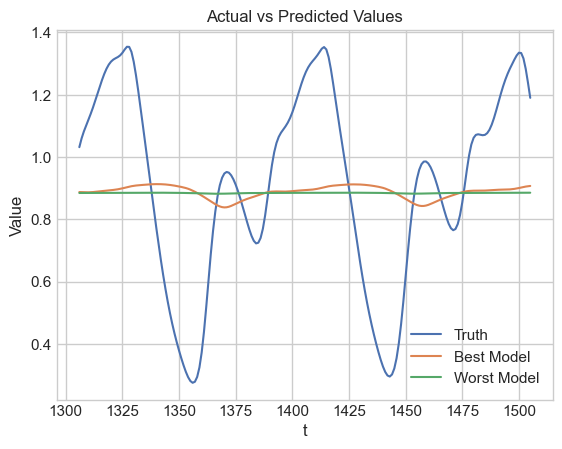

In [21]:
best_model = TimeSeriesMLP(hidden_nodes=(ranked_by_final[0][0]))
best_model.fit(X_train, y_train, X_val, y_val)
worst_model = TimeSeriesMLP(hidden_nodes=ranked_by_final[-1][0])
worst_model.fit(X_train, y_train, X_val, y_val)

data = {
    "t": steps[-200:]+5,
    "Truth": y_test,
    "Best Model": model.predict(X_test).flatten(),
    "Worst Model":worst_model.predict(X_test).flatten()
}
data = pd.DataFrame(data)
data = pd.melt(data, ["t"])
data.columns = ["t", "Model", "Value"]

sns.lineplot(data, x="t", y="Value", hue="Model")

plt.title('Actual vs Predicted Values')
plt.legend()

# Show the plot
plt.show()